# Decoding Nonlinear Signals in Multidimensional Precipitation Observations
### Interactive reproducity workflow

This code is meant to provide a reference for others to reproduce and expand up our work. For additional code, please see our GitHub repository (https://github.com/frasertheking/umap).

Below we load a random subsample (10%) of the full 12-dimensional dataset used in this study using gdown, and include multiple functions for visualization, analysis, and performing the linear/nonlinear dimensionality reduction. Even with the smaller subsample, results are consistent with what is reported using all of the data.

**To use this notebook, simply click "Run all" from the "Runtime" dropdown, and all necessary packages and datasets will automatically be downloaded.**

To use the full dataset, please see our data repository on DeepBlue (https://doi.org/10.7302/37yx-9q53).

### Contact
If you have any questions, please reach out to Fraser King (kingfr@umich.edu).

### Importing necessary libraries
This cell imports essential libraries for data analysis and visualization. Libraries include:
- `numpy` for numerical operations
- `pandas` for data manipulation
- `matplotlib` and `seaborn` for plotting
- `umap` for the UMAP algorithm, used for dimensionality reduction.


In [ ]:
##### IMPORTS
!python --version
!pip install umap-learn[plot]

import sys
import gdown
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import umap
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN
from matplotlib.colors import LogNorm
from psutil import virtual_memory
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 24})
# sys.path.append('/content/mitacs/pub_scripts')

ram_gb = virtual_memory().total / 1e9
print('\nYour runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Python 3.10.12

Your runtime has 13.6 gigabytes of available RAM



### Global Variables
Here we set a few global variables we will reference throughout the script.


In [ ]:
#### GLOBALS

SIGMA = 2
SEED = 42
COLORS = ['black', '#3cb44b', '#4363d8','#bfef45','#42d4f4',
          '#911eb4', '#ffe119','#e6194B', '#f032e6','#f58231']

### Download data
This cell uses gdown to download the 12-dimensional 10% subsample dataset that we use in this analysis. The file is ~4 MB and will be saved locally to your workspace for the duration of the interactive session. Note that the file will not permanently be saved to your Google Drive.


In [ ]:
#### DOWNLOADS

print("Downloading example microphysical dataset:")
data_url = "https://drive.google.com/uc?id=1OVk35gk7tF5_geUpHyi0vB6_2oI9a30S"
data_file = gdown.download(data_url)
data_file_path = '/content/pip_data_subset.csv'

Downloading...
From: https://drive.google.com/uc?id=1OVk35gk7tF5_geUpHyi0vB6_2oI9a30S
To: /content/pip_data_subset.csv
100%|██████████| 3.96M/3.96M [00:00<00:00, 83.2MB/s]


In [ ]:
#### INPUT VARIABLES

log_scale_vars = ['n0', 'lambda', 'Nt', 'Rho', 'Sr', 'Rr', 'Dm']
features = ['n0_log', 'lambda_log', 'Fs', 'Rho_log', 'Sr_log', 'Rr_log',
            'Nt_log', 't', 'rh', 'dp', 'p', 'ws']
inputs = ['n0_log_norm', 'lambda_log_norm', 'Fs_norm', 'Rho_log_norm',
          'Sr_log_norm', 'Rr_log_norm', 'Nt_log_norm', 't_norm', 'rh_norm',
          'dp_norm', 'p_norm', 'ws_norm']

### log_scale(): Helper function for log-scaling various inputs
def log_scale(data, var):
  data[var + '_log'] = np.log10(data[var])
  if var == 'Sr' or var == 'Rr':
    data[var + '_log'] = data[var + '_log'].replace(-np.inf, 0)

### normalize(): Helper function for normalizing inputs
def normalize(data, var):
  mean = data[var].mean()
  std = data[var].std()
  data[f"{var}_norm"] = (data[var] - mean) / std

### Loading the dataset
This cell loads the dataset from the CSV file we downloaded earlier using `pandas`. The dataset is stored in a DataFrame named `df`. This is the first step in preparing our data for analysis.


In [ ]:
#### LOAD AND SCALE

print("Loading and scaling data...")
df = pd.read_csv(data_file_path)
for var in log_scale_vars:
  log_scale(df, var)
for var in features:
  normalize(df, var)
scaled_inputs = df.loc[:, inputs].values

print("\nMicrophysical dataset shape:")
print(scaled_inputs.shape)

Loading and scaling data...

Microphysical dataset shape:
(18223, 12)


### Visualizing the inputs
Before we perform the dimensionality reduction, it is important that we examine the input variables and assess their suitability. This is a key first step as providing bad data to PCA/UMAP will result in less meaningful latent embeddings.


Plotting data overview...

Total rain/snow observations per site:


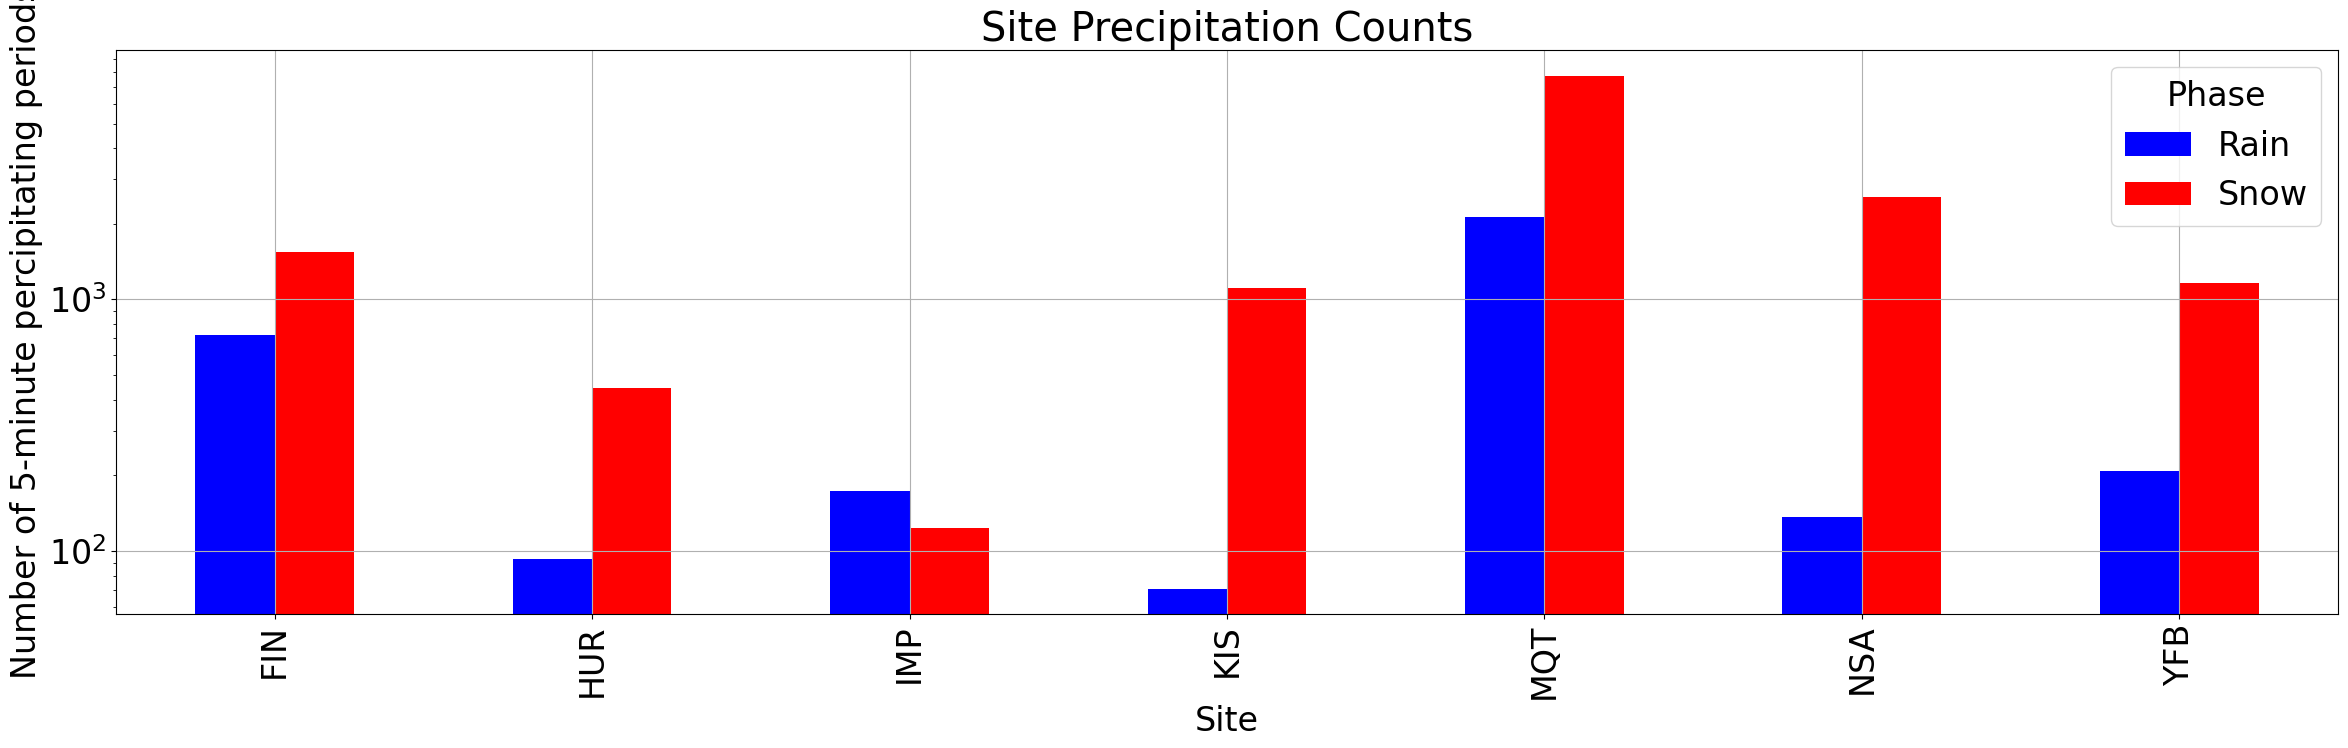


MET data distributions per site:


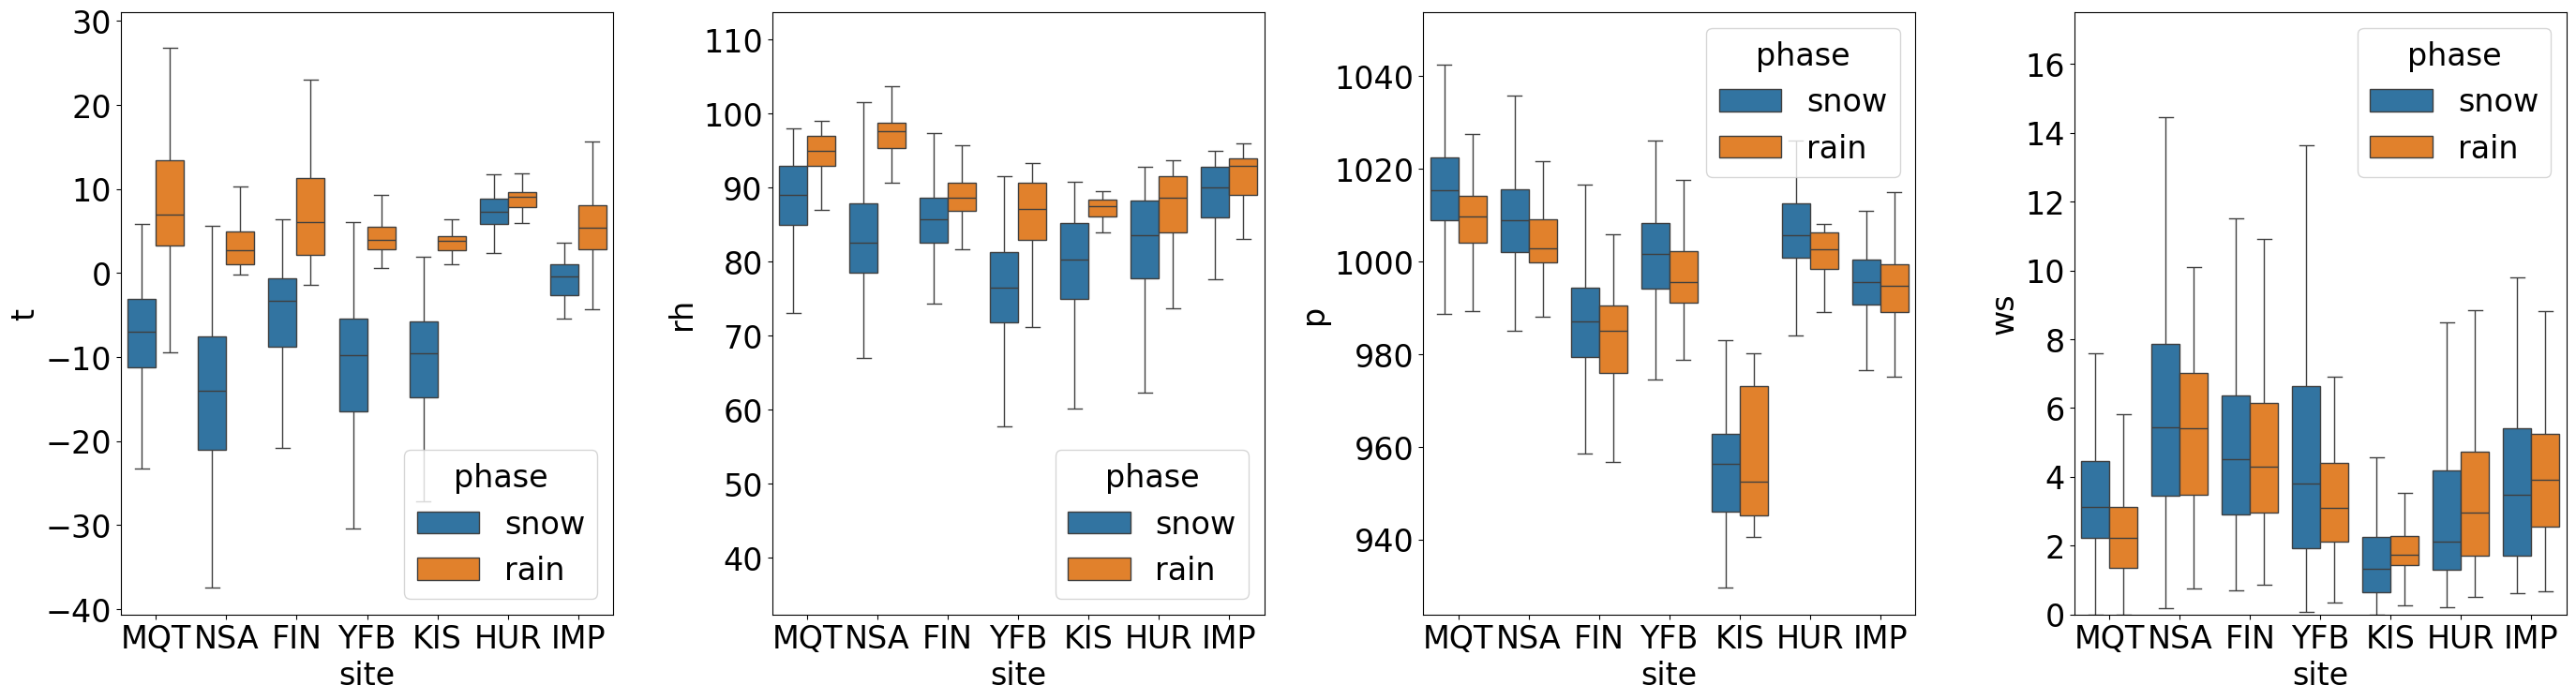


Rain joint 2D histograms:


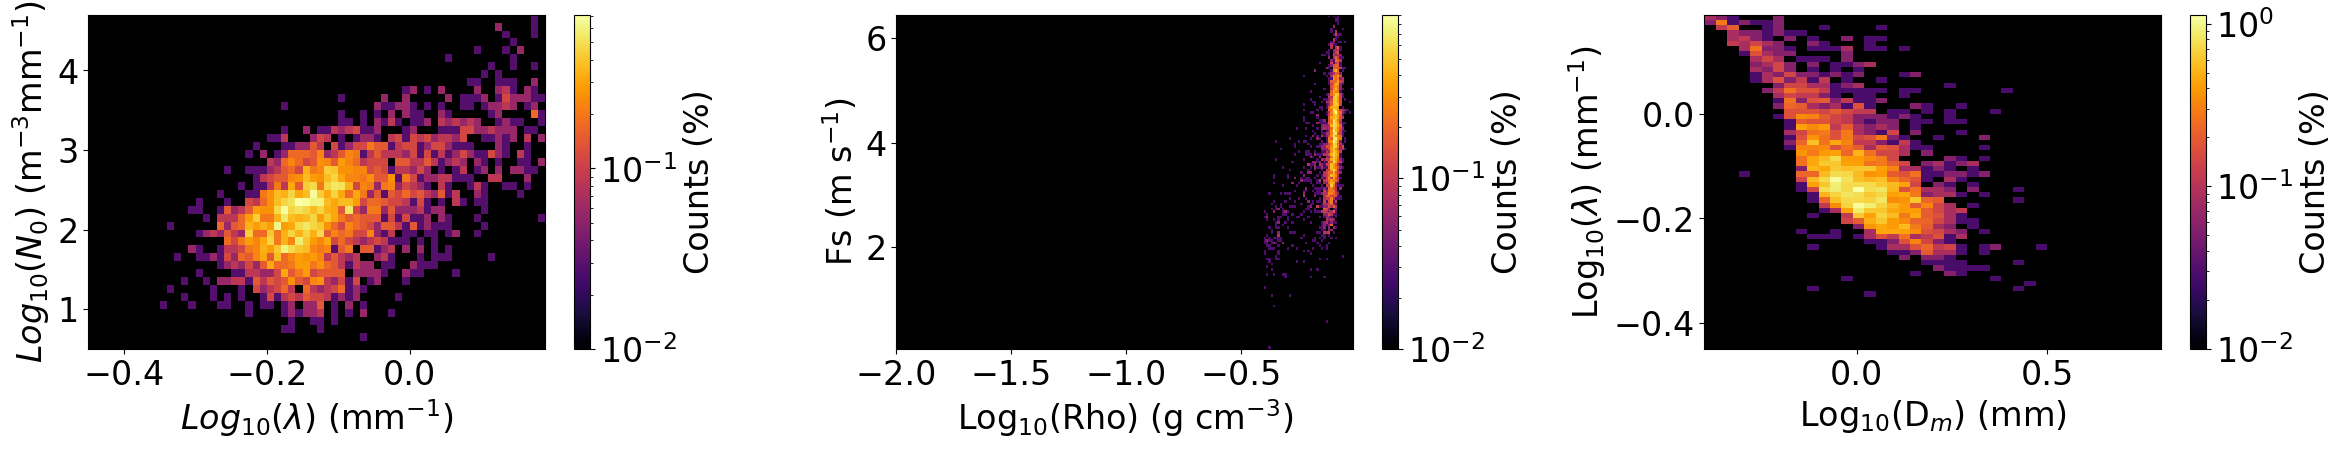


Snow joint 2D histograms:


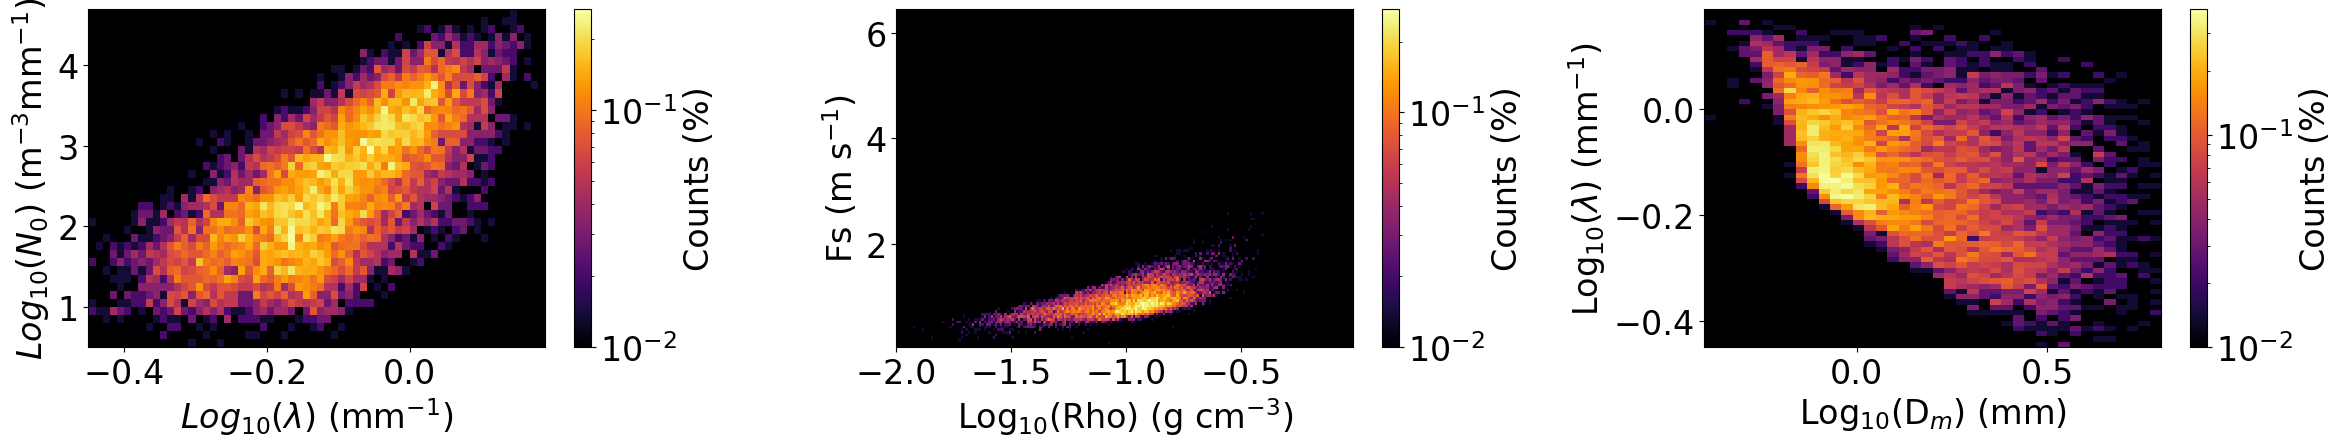

In [ ]:
#### DATA VISUALIZATION

### plot_site_counts(): Visualization function for plotting total rain/snow
###                     observations at each site
def plot_site_counts(data):
  print("\nTotal rain/snow observations per site:")
  df_t =pd.Series(data.groupby(['site','phase']).size()).unstack().reset_index()
  df_t.columns = ['Site', 'Rain', 'Snow']
  plt.rcParams.update({'font.size': 24})
  fig, ax = plt.subplots(figsize=(24, 8))
  df_t.plot(x='Site', y=['Rain','Snow'], kind='bar', ax=ax,color=['blue','red'])
  ax.grid()
  ax.set_yscale('log')
  ax.set_title('Site Precipitation Counts')
  ax.set_xlabel('Site')
  ax.set_ylabel('Number of 5-minute percipitating periods')
  plt.legend(title='Phase')
  plt.tight_layout()
  plt.show()

### plot_met(): Visualization function for plotting surface MET distributions
def plot_met(data):
  print("\nMET data distributions per site:")
  plt.rcParams.update({'font.size': 24})
  fig, axes = plt.subplots(1, 4, figsize=(28, 8))
  sns.boxplot(data=data, x="site", y="t", hue='phase', fliersize=0,  ax=axes[0])
  sns.boxplot(data=data, x="site", y="rh", hue='phase', fliersize=0, ax=axes[1])
  sns.boxplot(data=data, x="site", y="p", hue='phase', fliersize=0, ax=axes[2])
  sns.boxplot(data=data, x="site", y="ws", hue='phase', fliersize=0, ax=axes[3])
  axes[3].set_ylim((0,17.5))
  plt.tight_layout()
  plt.show()

### plot_hists(): Visualization function for plotting 2D histograms of various
###               PIP-derived particle microphysical observations (rain/snow)
def plot_hists(df, rho_min, rho_max, fs_min, fs_max, fs_step, type):
  bin_N0 = np.arange(0.5, 4.75, 0.1)
  bin_lambda = np.arange(-0.45, 0.2, 0.01)
  bin_rho = np.arange(rho_min, rho_max, 0.01)
  bin_fs = np.arange(fs_min, fs_max, fs_step)
  bin_dm = np.arange(-0.4, 0.8, 0.03)
  bin_lambda2 = bin_lambda.copy()

  cmap = plt.get_cmap('inferno')
  cmap.set_bad(color='black')

  print(f'\n{type} joint 2D histograms:')
  plt.rcParams.update({'font.size': 24})
  fig, axes = plt.subplots(1, 3, figsize=(24, 5))
  n0_l = np.histogram2d(df['lambda_log'], df['n0_log'], (bin_lambda, bin_N0))
  hist = 100 * n0_l[0].T / np.sum(n0_l[0].T)
  pcm = axes[0].pcolormesh(bin_lambda, bin_N0, hist, cmap=cmap,
                           norm=LogNorm(vmin=0.01, vmax=hist.max()))
  axes[0].set_facecolor('#440154')
  axes[0].set_xlabel("$Log_{10}(λ)$ (mm$^{-1}$)")
  axes[0].set_ylabel("$Log_{10}(N_{0})$ (m$^{-3}$mm$^{-1}$)")
  fig.colorbar(pcm, ax=axes[0], orientation='vertical').set_label("Counts (%)")

  rho_fs = np.histogram2d(df['Rho_log'], df['Fs'], (bin_rho, bin_fs))
  hist = 100 * rho_fs[0].T / np.sum(rho_fs[0].T)
  pcm = axes[1].pcolormesh(bin_rho, bin_fs, hist, cmap=cmap,
                           norm=LogNorm(vmin=0.01, vmax=hist.max()))
  axes[1].set_facecolor('#440154')
  axes[1].set_xlabel("Log$_{10}$(Rho) (g cm$^{-3}$)")
  axes[1].set_ylabel("Fs (m s$^{-1}$)")
  fig.colorbar(pcm, ax=axes[1], orientation='vertical').set_label("Counts (%)")

  dm_sr = np.histogram2d(df['Dm_log'], df['lambda_log'], (bin_dm, bin_lambda2))
  hist = 100 * dm_sr[0].T / np.sum(dm_sr[0].T)
  pcm = axes[2].pcolormesh(bin_dm, bin_lambda2, hist, cmap=cmap,
                           norm=LogNorm(vmin=0.01, vmax=hist.max()))
  axes[2].set_facecolor('#440154')
  axes[2].set_xlabel("Log$_{10}$(D$_m$) (mm)")
  axes[2].set_ylabel("Log$_{10}$($\lambda$) (mm$^{-1}$)")
  fig.colorbar(pcm, ax=axes[2], orientation='vertical').set_label("Counts (%)")
  plt.tight_layout()
  plt.show()


df_snow = df[df['phase'] == 'snow']
df_rain = df[df['phase'] == 'rain']

print("Plotting data overview...")
plot_site_counts(df)
plot_met(df)
plot_hists(df_rain, -2, 0, 0.05, 6.5, 0.05, 'Rain')
plot_hists(df_snow, -2, 0, 0.05, 6.5, 0.05, 'Snow')

### Fit PCA
Now that we have our data normalized and have checked the visualizations for physical consistency with expected distributions of microphysical properites, we can perform the linear decomposition. For this we use scikit-learn's PCA decomposition (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). We also show a plot of the explained variance to get an idea of which EOFs are dominant.



Fitting PCA...

PCA fit!
(18223, 8)

Explained variance:
[0.31089453 0.23661334 0.09997658 0.08414605 0.08001204 0.0730718
 0.0460148  0.03755911]


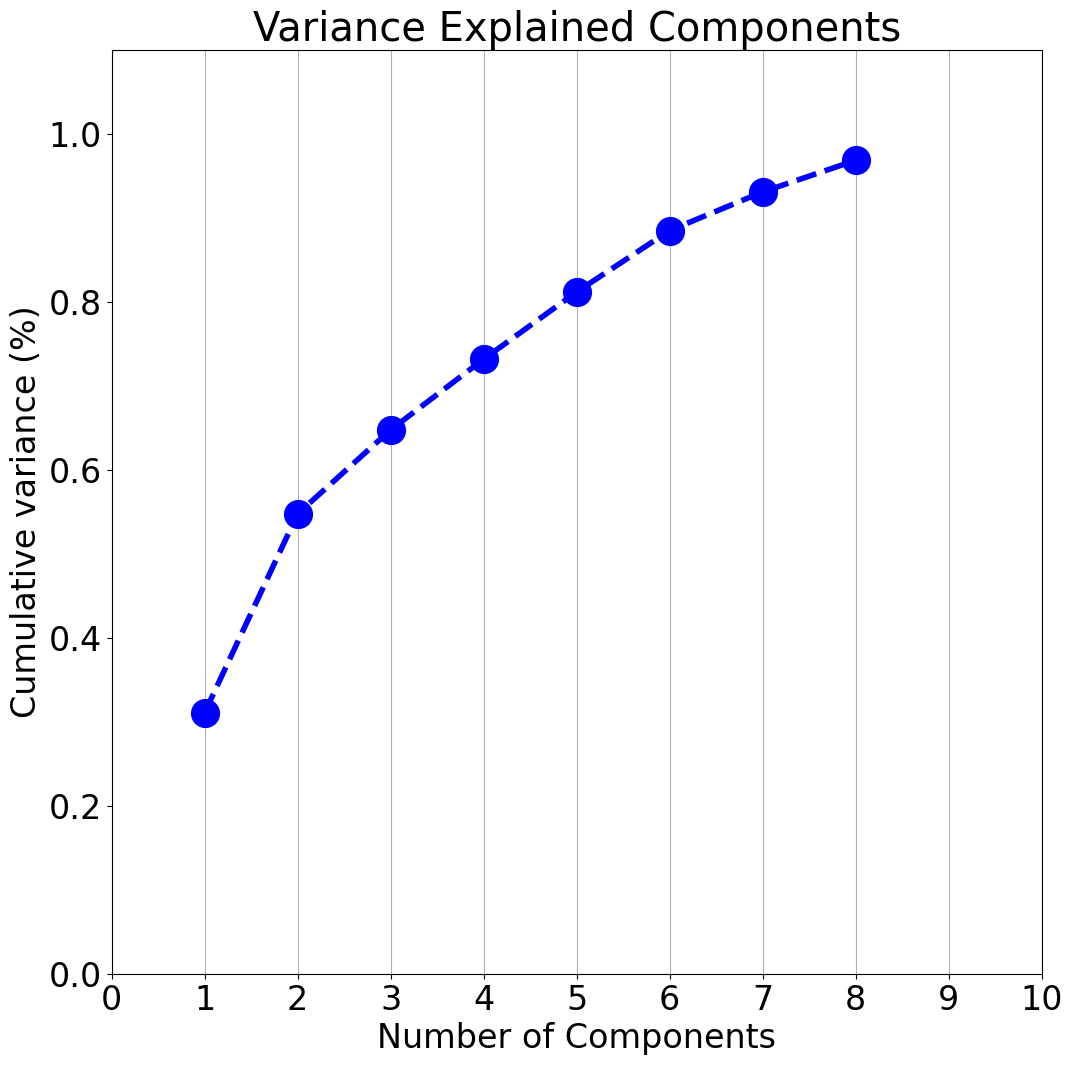

In [ ]:
##### PCA Fit

### run_pca(): Helper function for fitting the PCA to the input data
def run_pca(data):
  global df
  print("\nFitting PCA...")
  pca = PCA(n_components = 0.95)
  pca.fit(scaled_inputs)
  pca_embedding = pca.transform(scaled_inputs)

  print("\nPCA fit!")
  print(pca_embedding.shape)
  print("\nExplained variance:")
  print(pca.explained_variance_ratio_)

  fig, ax = plt.subplots(figsize=(12,12))
  y = np.cumsum(pca.explained_variance_ratio_)
  xi = np.arange(1, len(y)+1, step=1)
  plt.ylim(0.0,1.1)
  plt.plot(xi, y, marker='o', linestyle='--', linewidth=4, markersize=20,
           color='b')
  plt.xlabel('Number of Components')
  plt.xticks(np.arange(0, 11, step=1))
  plt.ylabel('Cumulative variance (%)')
  plt.title('Variance Explained Components')
  ax.grid(axis='x')
  plt.show()

  cols=[]
  for i in range(pca_embedding.shape[1]):
      cols.append('pca_eof' + str(i+1))
  principalDf = pd.DataFrame(data = pca_embedding, columns = cols)
  df = df.reset_index(drop=True)
  principalDf = principalDf.reset_index(drop=True)
  df = pd.concat([df, principalDf], axis=1)

  return pca_embedding, cols, principalDf, pca

pca_embedding, cols, principalDf, pca = run_pca(df)

### Visualize PCA EOFs
Next we can visualize what the PCA EOFs look like via their joint value distributions and EOF values. Note that as we move from EOF1 to EOF2 and EOF3 the distribution becomes narrower.


PCA results:


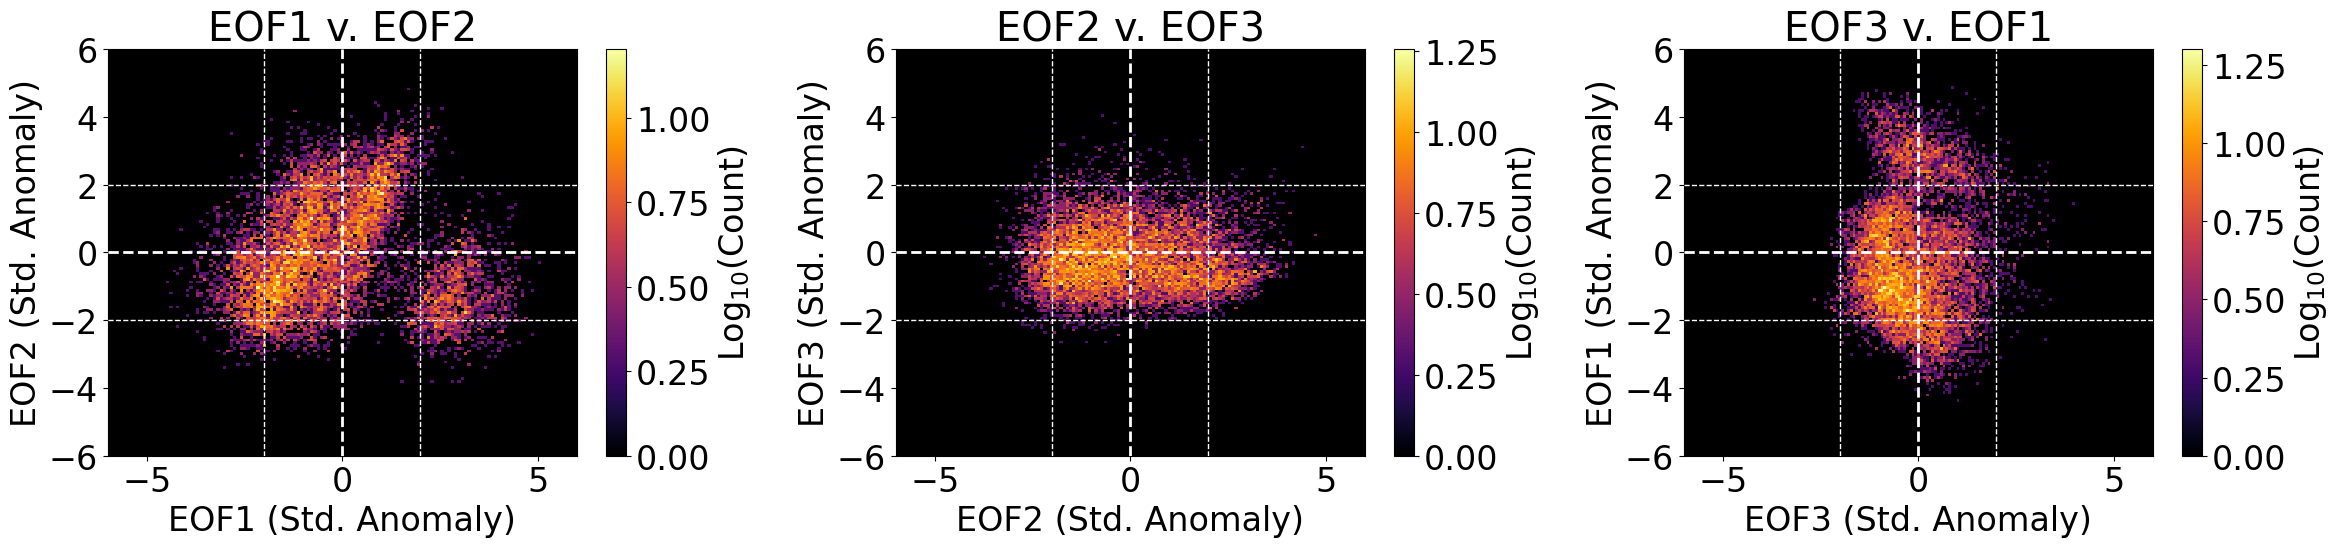

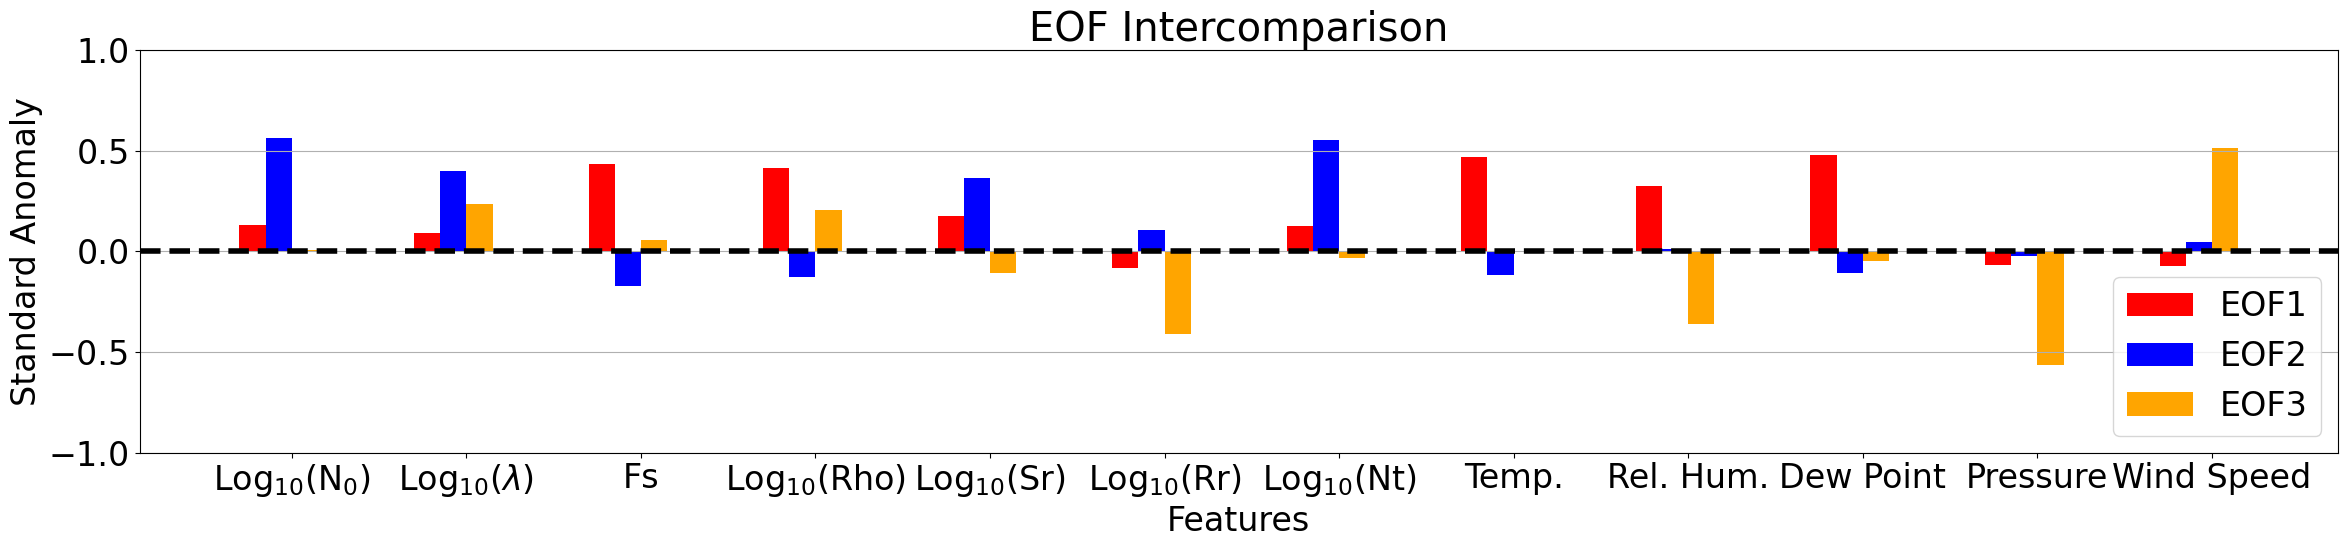

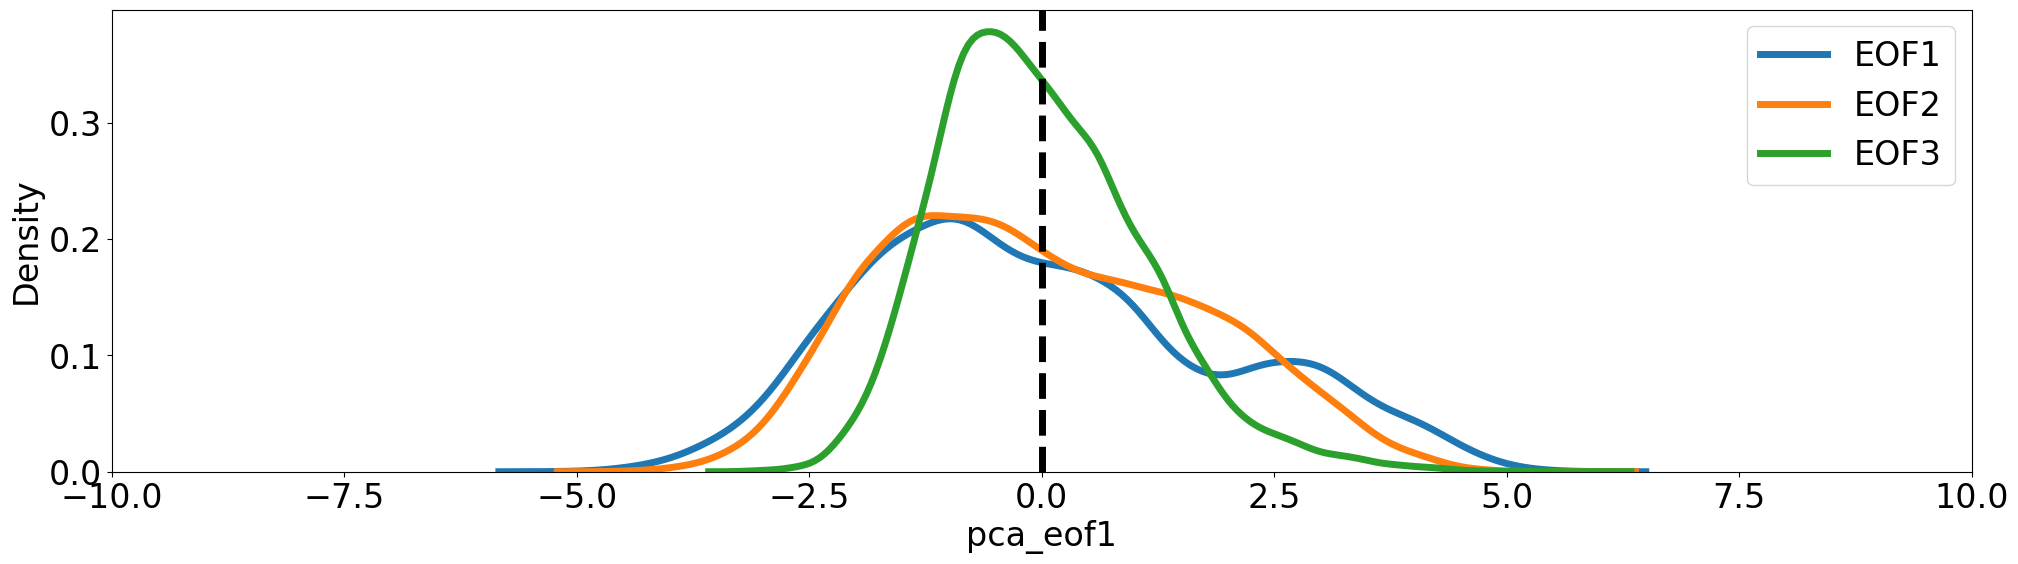

In [ ]:
### plot_pca_eofs: Another visualization function for plotting diagnostic
###                graphs showing the PCA EOF distributions
def plot_pca_eofs(cols, principalDf, pca):
  loadings = pd.DataFrame(pca.components_.T, columns=cols,
            index=['Log$_{10}$(N${_0}$)', 'Log$_{10}$($\lambda$)',
                    'Fs', 'Log$_{10}$(Rho)', 'Log$_{10}$(Sr)',
                    'Log$_{10}$(Rr)', 'Log$_{10}$(Nt)', 'Temp.', 'Rel. Hum.',
                    'Dew Point', 'Pressure', 'Wind Speed'])

  ### make_pca_plot(): Plot 2D joint distributions
  def make_pca_plot(ax, pc_a, pc_b, xlabel, ylabel, title, colmap):
    ax.set_facecolor('white')
    ax.set_facecolor('black')
    extent = 6
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.axhline(SIGMA, linewidth=1, color='white', linestyle='--', zorder=1001)
    ax.axvline(-SIGMA, linewidth=1, color='white', linestyle='--', zorder=1001)
    ax.axhline(-SIGMA, linewidth=1, color='white', linestyle='--', zorder=1001)
    ax.axvline(SIGMA, linewidth=1, color='white', linestyle='--', zorder=1001)
    ax.axhline(0, linewidth=2, color='white', linestyle='--', zorder=1001)
    ax.axvline(0, linewidth=2, color='white', linestyle='--', zorder=1001)
    ax.set_xlim((-extent, extent))
    ax.set_ylim((-extent, extent))

    counts, xedges, yedges = np.histogram2d(pc_a, pc_b, bins=125)
    counts = np.where(counts < 1, np.nan, counts)
    counts = np.log10(counts)
    pcm = ax.pcolormesh(xedges, yedges, counts.T, cmap=colmap, rasterized=True,
                        zorder=1000)
    cbar = plt.colorbar(pcm, ax=ax, label='Log$_{10}$(Count)')
    cbar.ax.minorticks_off()

  c = 'inferno'
  fig, axes = plt.subplots(1, 3, figsize=(24, 6))
  make_pca_plot(axes[0], principalDf['pca_eof1'], principalDf['pca_eof2'],
                'EOF1 (Std. Anomaly)', 'EOF2 (Std. Anomaly)', f'EOF1 v. EOF2',c)
  make_pca_plot(axes[1], principalDf['pca_eof2'], principalDf['pca_eof3'],
                'EOF2 (Std. Anomaly)', 'EOF3 (Std. Anomaly)', f'EOF2 v. EOF3',c)
  make_pca_plot(axes[2], principalDf['pca_eof3'], principalDf['pca_eof1'],
                'EOF3 (Std. Anomaly)', 'EOF1 (Std. Anomaly)', f'EOF3 v. EOF1',c)
  plt.tight_layout()
  plt.show()

  ### Plot EOF standard anoms by variable
  fig, ax = plt.subplots(figsize=(24,6))
  x = np.arange(len(loadings.index))
  bar_width = 0.15

  ax.bar(x - bar_width - bar_width/2, loadings['pca_eof1'], width=bar_width,
         color='red', edgecolor='#d72e1f', linewidth=0, label='EOF1')
  ax.bar(x - bar_width/2, loadings['pca_eof2'], width=bar_width, color='blue',
         edgecolor='#0000dc', linewidth=0,  label='EOF2')
  ax.bar(x + bar_width/2, loadings['pca_eof3'], width=bar_width,color='orange',
         edgecolor='#df9b36', linewidth=0,  label='EOF3')

  ax.set_title('EOF Intercomparison')
  ax.set_ylabel('Standard Anomaly')
  ax.set_xlabel('Features')
  ax.set_xticks(x)
  ax.set_xticklabels(loadings.index)
  ax.grid(True, axis='y')
  ax.set_ylim((-1, 1))
  ax.axhline(0, linewidth=4, linestyle='--', color='black')
  ax.legend(loc='lower right')
  plt.tight_layout()
  plt.show()

  ### Plot 1D distributions
  fig, ax = plt.subplots(figsize=(24, 6))
  plt.xlim((-10, 10))
  sns.kdeplot(data=principalDf, x="pca_eof1", label='EOF1', linewidth=5)
  sns.kdeplot(data=principalDf, x="pca_eof2", label='EOF2', linewidth=5)
  sns.kdeplot(data=principalDf, x="pca_eof3", label='EOF3', linewidth=5)
  plt.axvline(0, linestyle='--', color='black', linewidth=5)
  plt.legend()
  plt.show()

print("PCA results:")
plot_pca_eofs(cols, principalDf, pca)

### Manual PCA clustering
Next we perform the PCA clustering as described in Dolan et al., (2018) and King et al., 2024. The sigma=2 threshold was selected via a sensitivity analysis.


In [ ]:
### manual_pc_group_cluster(): Manual PCA clustering methodology
def manual_pc_group_cluster(data):
    groups = {
        1: [
            [[-np.inf, -SIGMA], [-np.inf, np.inf], [-SIGMA, SIGMA]]
        ],
        2: [
            [[-SIGMA, SIGMA], [SIGMA, np.inf], [-np.inf, np.inf]]
        ],
        3: [
            [[SIGMA, np.inf], [-np.inf, np.inf], [-SIGMA, SIGMA]]
        ],
        4: [
            [[-SIGMA, SIGMA], [-np.inf, -SIGMA], [-np.inf, np.inf]]
        ],
        5: [
            [[-np.inf, np.inf], [-SIGMA, SIGMA], [SIGMA, np.inf]]
        ],
        6: [
            [[-np.inf, np.inf], [-SIGMA, SIGMA], [-np.inf, -SIGMA]]
        ]
    }

    def assign_group(row):
        for group, conditions in groups.items():
            for condition in conditions:
                range1, range2, range3 = condition
                if range1[0] <= row['pca_eof1'] <= range1[1] and \
                   range2[0] <= row['pca_eof2'] <= range2[1] and \
                   range3[0] <= row['pca_eof3'] <= range3[1]:
                    return group
        return 7 # ambiguous

    pca_groups_eof = data
    pca_groups_eof['pca_cluster'] = pca_groups_eof.apply(assign_group, axis=1)
    pca_groups_eof = pca_groups_eof['pca_cluster']
    return pca_groups_eof

df['pca_groups'] = manual_pc_group_cluster(df)


### Applying UMAP for dimensionality reduction
This cell initializes and applies the UMAP algorithm to the dataset. The `fit_transform` method reduces the data to a specified number of dimensions (typically 2 or 3) for visualization or further analysis.

Note that since we are using 10% of the data in this example, the n_neighbors is scaled to 1/10th what is used in the manuscript. Also, with a smaller dataset, the exact cluster positions/numbers change slightly (however the underlying structure remains consistent).


In [ ]:
##### UMAP Fit

### run_umap(): Fit UMAP using the same inputs as the PCA.
def run_umap():
  print("Performing UMAP fit, please wait as this typically takes 4 minutes...")
  reducer = umap.UMAP(n_neighbors=75, min_dist=0.22, n_components=3,
                      metric='canberra')
  umap_embedding = reducer.fit_transform(scaled_inputs)
  print("UMAP fit complete!")
  print(umap_embedding.shape)
  return umap_embedding

umap_embedding = run_umap()

Performing UMAP fit, please wait as this typically takes 4 minutes...
UMAP fit complete!
(18223, 3)


### Apply HDBSCAN for clustering
We next use the scikit-learn HDBSCAN implementation to cluster the groups generated from the UMAP coordinate embedding. For more information, please see (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html).


In [ ]:
##### HDBSCAN Clusters

### run_hdbscan(): Generate HDBSCAN clusters based on UMAP coordinates
def run_HDBSCAN(embedding):
  global df
  hdb_df = pd.DataFrame(data={'eof1': embedding[:, 0],
                              'eof2': embedding[:, 1],
                              'eof3': embedding[:, 2]})
  df['le1'] = embedding[:, 0]
  df['le2'] = embedding[:, 1]
  df['le3'] = embedding[:, 2]
  scan = HDBSCAN(min_cluster_size=500,cluster_selection_epsilon=0.3).fit(hdb_df)
  df['hdb_cluster'] = scan.labels_ + 1
  print("HDBSCAN complete! Total clusters:")
  print(np.unique(df['hdb_cluster']))

run_HDBSCAN(umap_embedding)


HDBSCAN complete! Total clusters:
[0 1 2 3 4 5]


### Visualizing UMAP
Similar to what we did for the PCA results, we examing the coordinate structure of the LE1/LE2/LE3 embeddings from UMAP (colored by their respective HDBSCAN values).


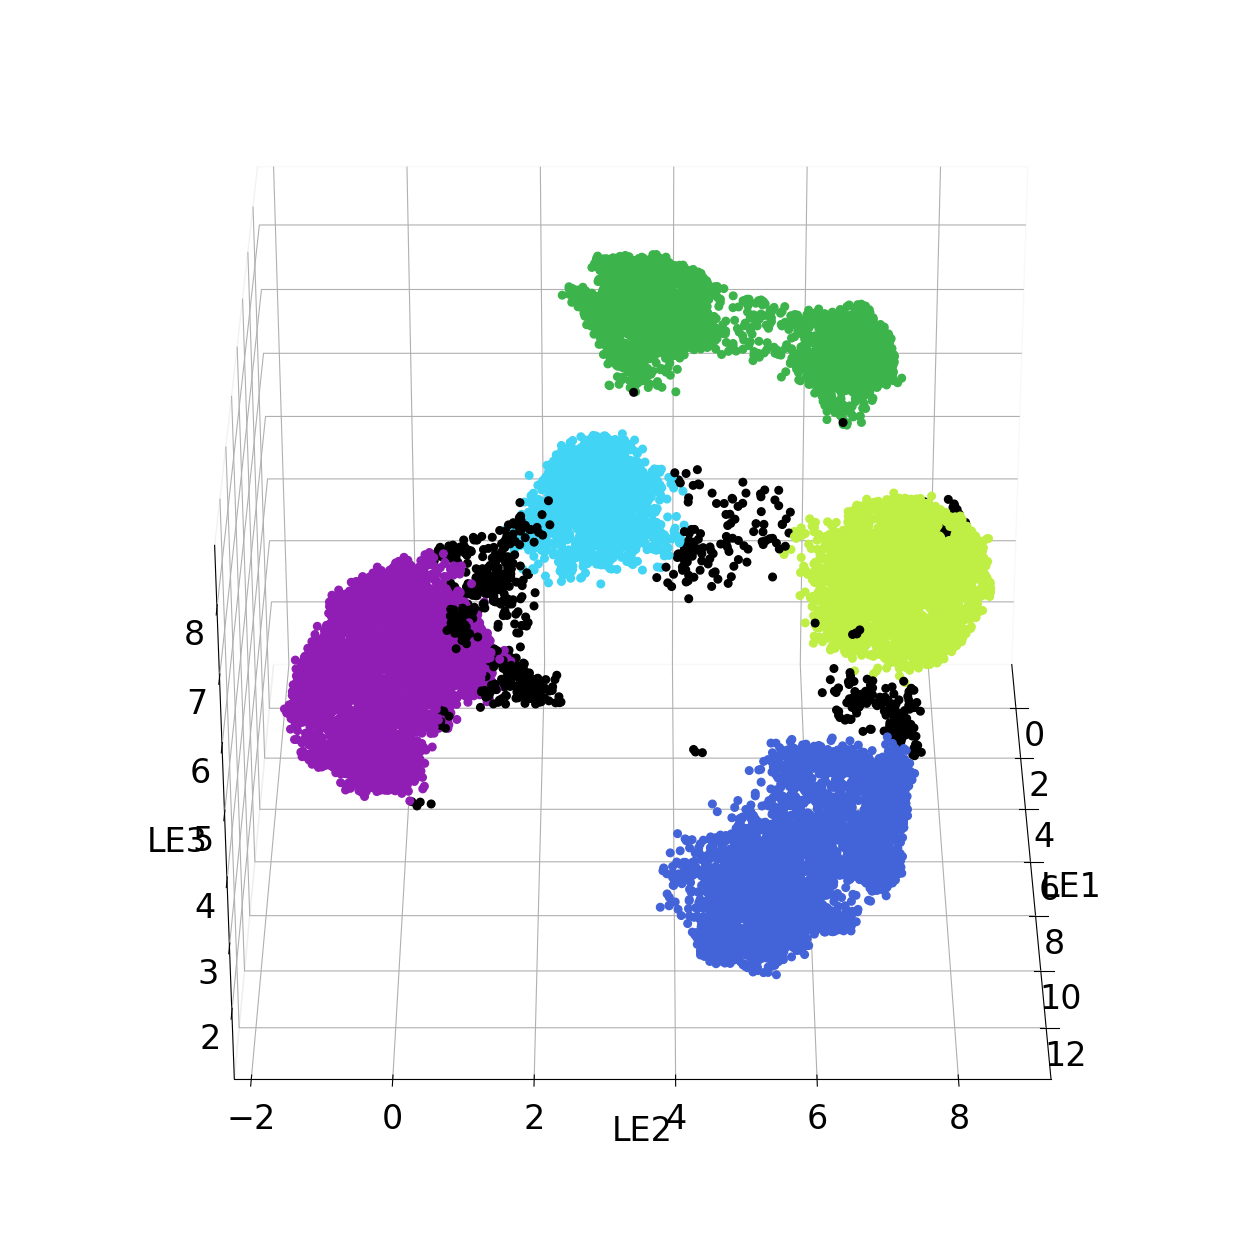

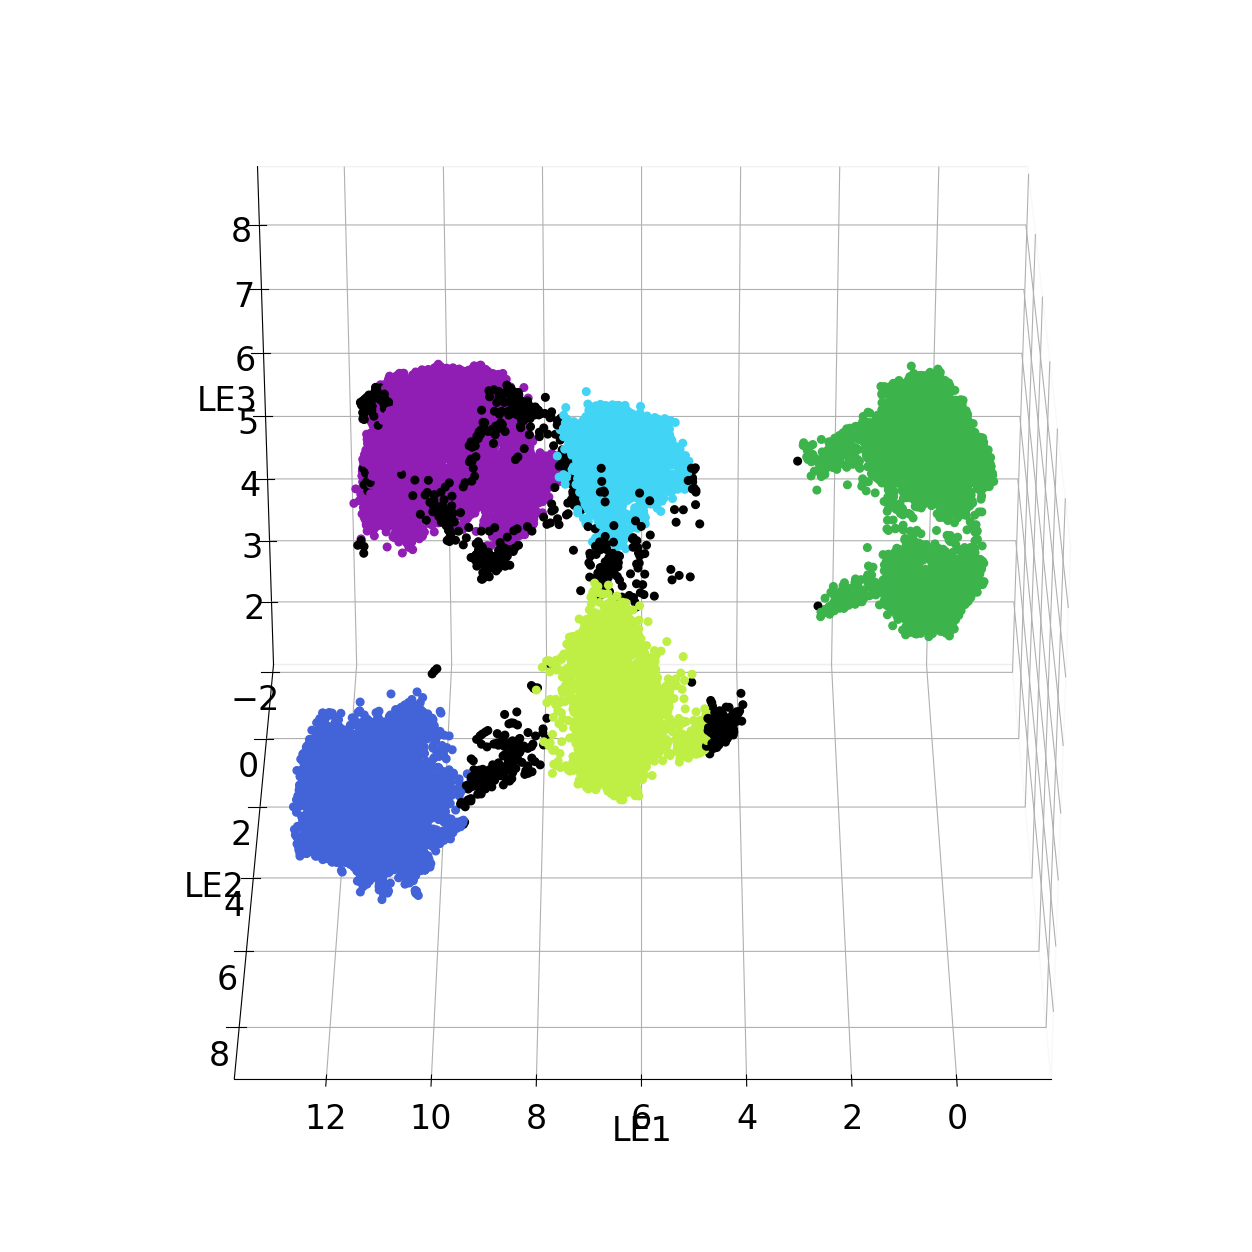

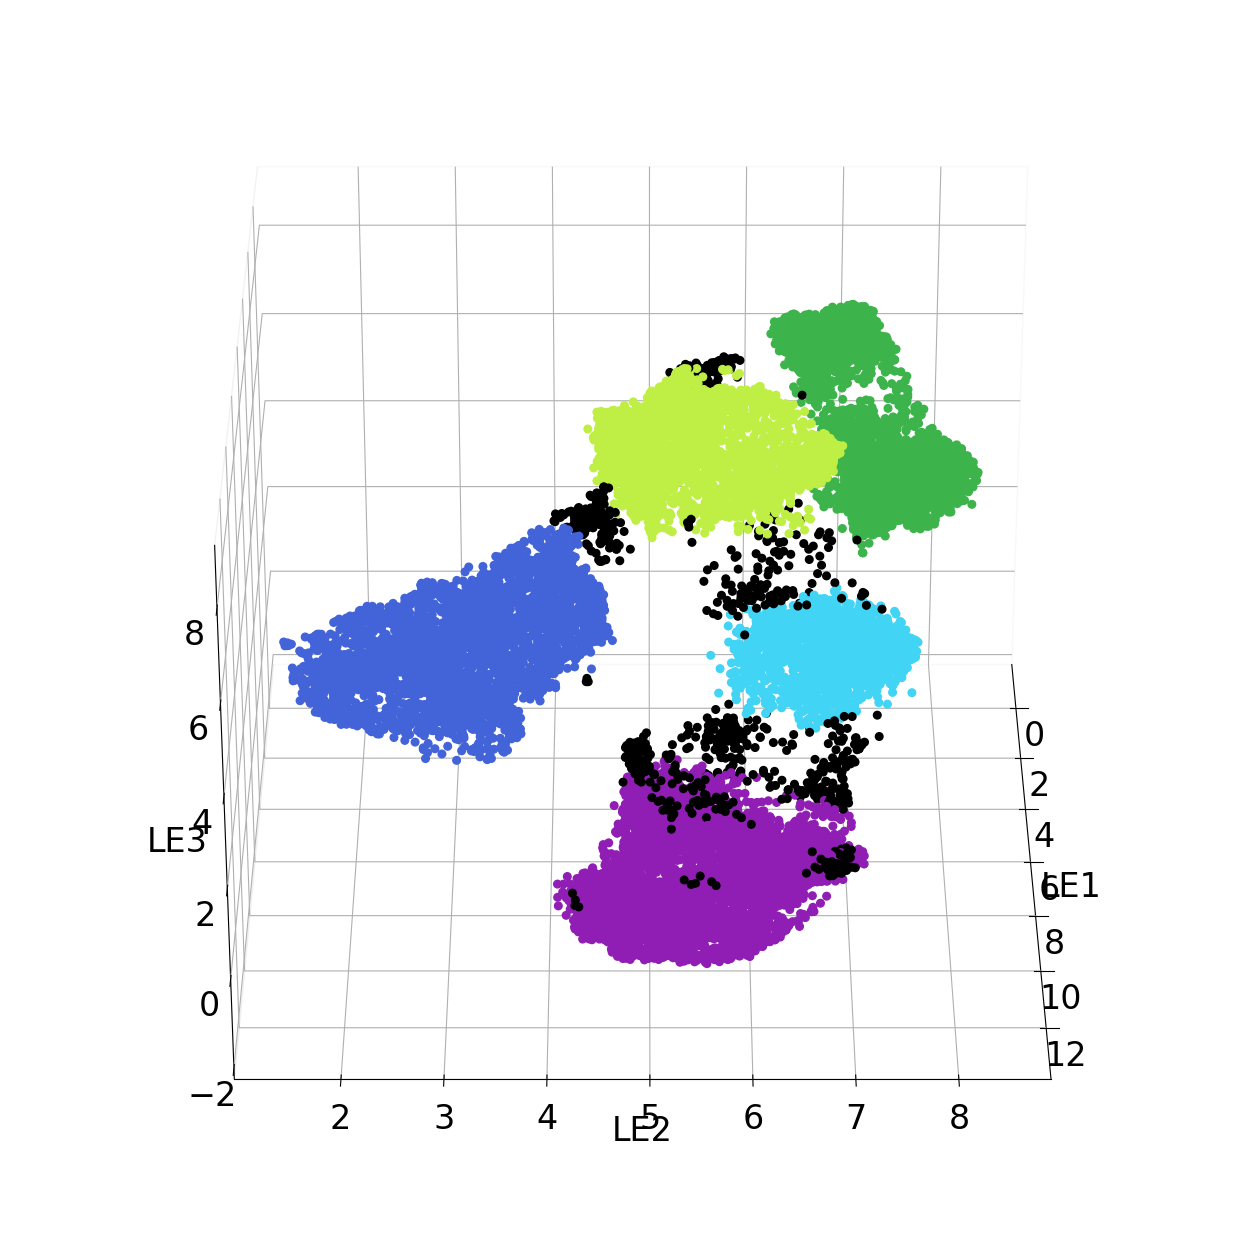

In [ ]:
##### UMAP Visualization

### plot_hdb_clusters(): Plot clusters in UMAP coordinate space
def plot_hdb_clusters(df_t, lab1, lab2, lab3, elev=30, azim=90):
  global df
  unique_clusters = np.unique(df['hdb_cluster'])
  df_t['cluster_db'] = df['hdb_cluster'].values

  cluster_colors = {cluster: color for cluster, color in zip(unique_clusters,
                                                             COLORS)}
  point_colors = [cluster_colors[cluster] for cluster in df_t['cluster_db']]

  fig = plt.figure(figsize=(16, 16))
  ax = fig.add_subplot(111, projection='3d')
  ax.set_xlabel('LE1', fontsize=24)
  ax.set_ylabel('LE2', fontsize=24)
  ax.set_zlabel('LE3', fontsize=24)
  ax.xaxis.pane.fill = False
  ax.yaxis.pane.fill = False
  ax.zaxis.pane.fill = False
  ax.tick_params(axis='x', which='major', labelsize=24)
  ax.tick_params(axis='y', which='major', labelsize=24)
  ax.tick_params(axis='z', which='major', labelsize=24)
  ax.grid(True)

  ax.scatter(df_t['le1'], df_t['le2'], df_t['le3'], s=30, c=point_colors,
             alpha=1)
  ax.view_init(elev=elev, azim=azim)

  plt.show()


plot_hdb_clusters(pd.DataFrame(data={'le1': df['le1'],
                                     'le2': df['le2'],
                                     'le3': df['le3']}),
                  'le1', 'le2', 'le3', azim=0)
plot_hdb_clusters(pd.DataFrame(data={'le1': df['le1'],
                                     'le2': df['le2'],
                                     'le3': df['le3']}),
                  'le1', 'le2', 'le3', azim=90)
plot_hdb_clusters(pd.DataFrame(data={'le1': df['le1'],
                                     'le2': df['le3'],
                                     'le3': df['le2']}),
                  'le1', 'le2', 'le3', elev=30, azim=0)

### Visualizing input variables
If we map input variables like temperature (T) and total particle count (Nt) to the UMAP coordinate space (LE1/LE2), we see a smooth gradient of values across the manifold. This is important as it is suggestive of a preservation of the physical global structure of the data (see https://umap-learn.readthedocs.io/en/latest/plotting.html).


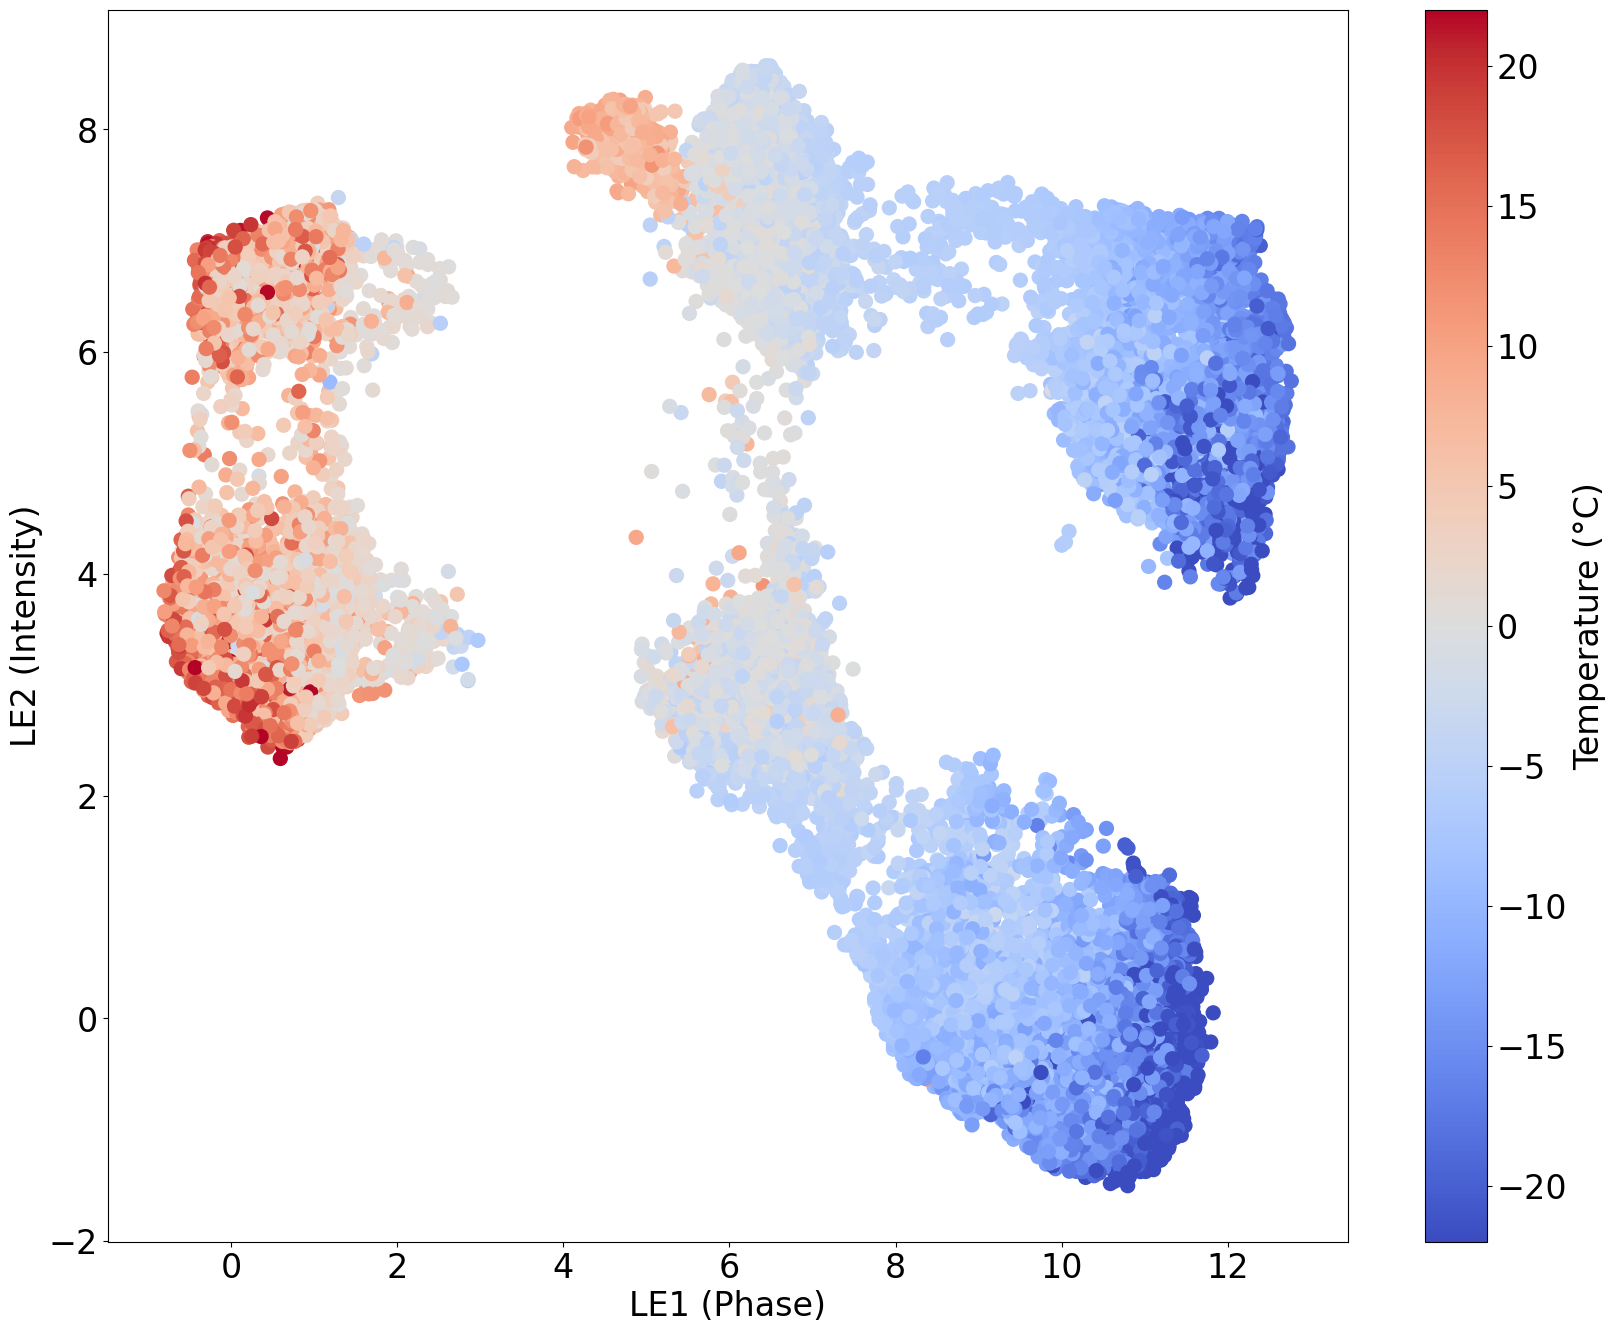

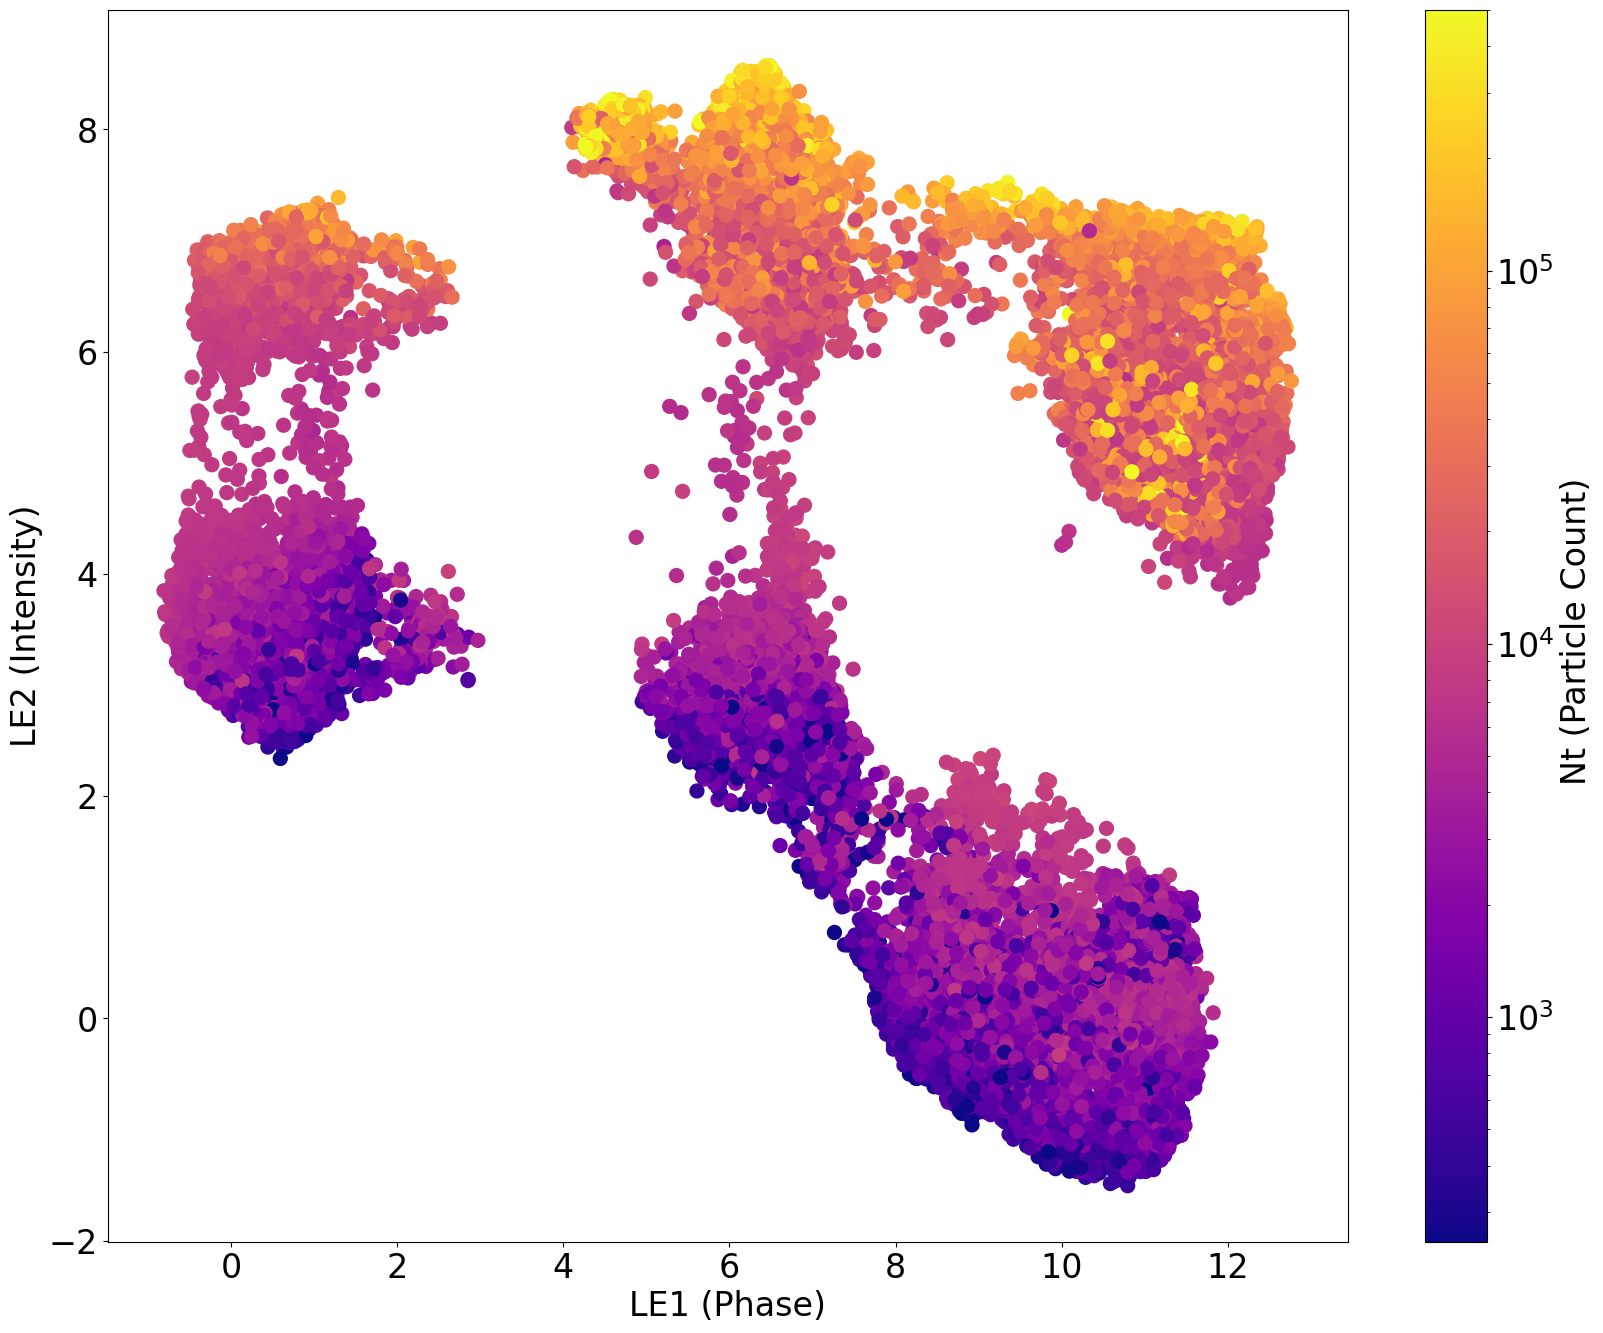

In [ ]:
###  plot_umap_joint(): Viz function for plotting 2d scatters of various
###                     UMAP variables, colored by related MET variables
def plot_umap_joint(df, col, norm, lab1, lab2, xlab, ylab, cmap, title, units):
  fig, ax = plt.subplots(figsize=(20,16))
  plt.ylabel(xlab)
  plt.xlabel(ylab)
  if norm:
      scatter = plt.scatter(df[lab1], df[lab2], s=100, c=col, cmap=cmap,
                            norm=LogNorm(vmin=250, vmax=500000), alpha=1)
  else:
      scatter = plt.scatter(df[lab1], df[lab2], s=100, c=col, cmap=cmap,
                            alpha=1, vmin=-22, vmax=22)
  cbar = fig.colorbar(scatter, ax=ax)
  cbar.set_label(f'{title} {units}')
  plt.show()

plot_umap_joint(pd.DataFrame(data={'le1': df['le1'], 'le2': df['le2']}),
                df['t'], False, 'le1', 'le2', 'LE2 (Intensity)',
                'LE1 (Phase)', 'coolwarm', 'Temperature', '(°C)')
plot_umap_joint(pd.DataFrame(data={'le1': df['le1'], 'le2': df['le2']}),
                df['Nt'], True, 'le1', 'le2', 'LE2 (Intensity)',
                'LE1 (Phase)', 'plasma', 'Nt (Particle Count)', '')

### UMAP comparisons to PCA
Finally, we show an example of what the PCA EOF1/EOF2 distributions look like when compared to the UMAP LE1/LE2. We see much greater separation using the nonlinear technique.


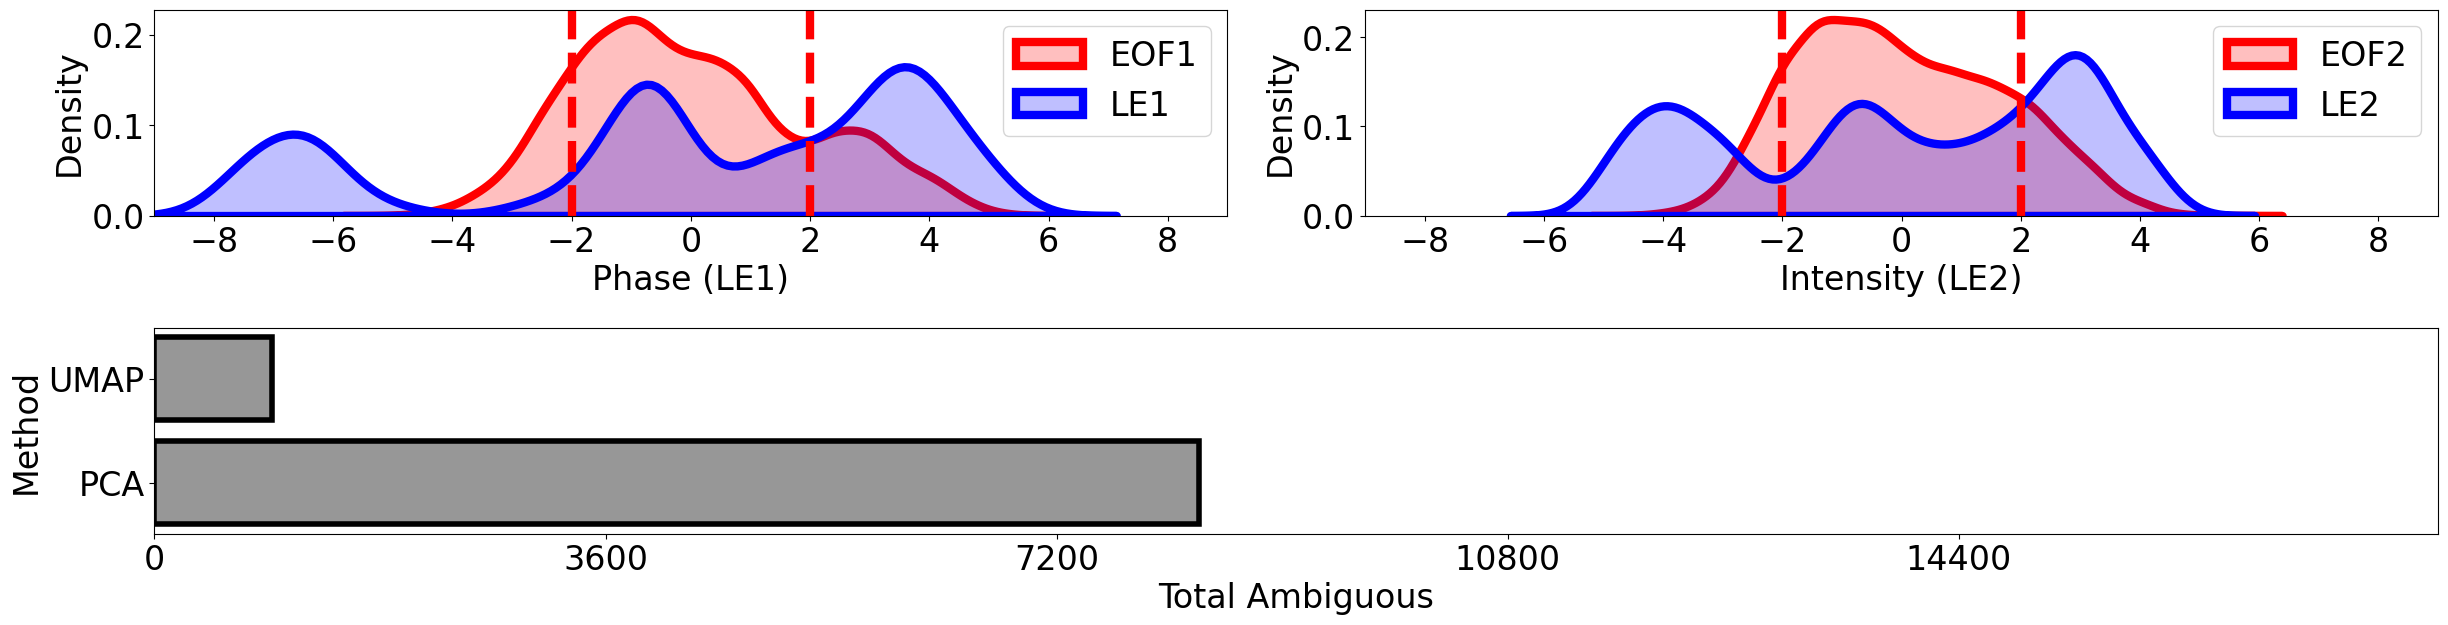

In [ ]:
# make_1d_kde_comparisons(): Viz for comparing PCA and UMAP EOFs/LEs
def make_1d_kde_comparisons(df):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(25, 7))
    df['le1_centered'] = df['le1'] - df['le1'].mean()
    df['le2_centered'] = df['le2'] - df['le2'].mean()
    df['le3_centered'] = df['le3'] - df['le3'].mean()

    sns.kdeplot(data=df['pca_eof1'], ax=axs[0][0], color='red',
                linewidth=6, label='EOF1', fill=True)
    sns.kdeplot(data=df['le1_centered'], ax=axs[0][0], color='blue',
                linewidth=6, label='LE1', fill=True)
    axs[0][0].set_xlabel('Phase (LE1)')
    axs[0][0].set_xlim((-9, 9))
    axs[0][0].axvline(-2, linestyle='--', linewidth=6, color='red')
    axs[0][0].axvline(2, linestyle='--', linewidth=6, color='red')
    axs[0][0].legend()

    sns.kdeplot(data=df['pca_eof2'], ax=axs[0][1], color='red',
                linewidth=6, label='EOF2', fill=True)
    sns.kdeplot(data=df['le2_centered'], ax=axs[0][1], color='blue',
                linewidth=6, label='LE2', fill=True)
    axs[0][1].set_xlabel('Intensity (LE2)')
    axs[0][1].set_xlim((-9, 9))
    axs[0][1].axvline(-2, linestyle='--', linewidth=6, color='red')
    axs[0][1].axvline(2, linestyle='--', linewidth=6, color='red')
    axs[0][1].legend()
    fig.delaxes(axs[1][0])
    fig.delaxes(axs[1][1])

    axs[1][1] = fig.add_subplot(2, 1, 2)
    axs[1][1].barh(['PCA', 'UMAP'], [(df['pca_groups'] == 7).sum(),
     (df['hdb_cluster'] == 0).sum()], color=['#979797', '#979797'],
                   edgecolor=['black', 'black'], linewidth=4, alpha=1)
    axs[1][1].set_xlim((0, len(df)))
    axs[1][1].set_ylabel('Method')
    axs[1][1].set_xlabel('Total Ambiguous')
    xticks = axs[1][1].get_xticks()
    axs[1][1].set_xticks(np.arange(0, 18000, 3600))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)

    plt.show()

make_1d_kde_comparisons(df)

Thanks for viewing our interactive notebook! If you would like additional information please see our associated manuscript.